- 참고(CAM 이론): https://tyami.github.io/deep%20learning/CNN-visualization-Grad-CAM/
- 참고(CNN 이론): https://tyami.github.io/medical%20image%20analysis/MEDIA-5-classification-for-medical-image-3-CNN/
- 참고(): 

# 프로젝트: CAM을 만들고 평가해 보자

## 라이브러리 버전 확인하기
---
사용할 라이브러리 버전을 확인해봐요.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import cv2
import PIL

import matplotlib.pyplot as plt

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

tf.config.list_physical_devices('GPU')

/Users/louan/.pyenv/versions/3.9.13/envs/img/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.11.0
1.24.1
4.7.0
9.4.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## CAM 구현하기
---
1. 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

- CAM의 구조: 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성

- Image Handling
- 사용할 데이터셋: 스탠포드 dogs

In [3]:
# image load
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-14 23:03:05.304019: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-14 23:03:05.304337: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# <Pooling options>: https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19/VGG19
# avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
# max means that global max pooling will be applied.
num_classes = ds_info.features['label'].num_classes

vgg19_base_model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg', 
)
x = vgg19_base_model.output
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = tf.keras.Model(inputs = vgg19_base_model.input, outputs = x)

In [5]:
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### image processing

In [6]:
# tf.cast 함수: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=wideeyed&logNo=221158018178

def normalize_and_resize_img(input):
    '''
    stanfor_dog의 image item 하나를 받아서 image를 resize, normalize하고 텐서로 변환 후 image와 label return
    '''
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


2023-03-14 23:03:22.449766: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [8]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

- 위와 같이 진행해도 되나.. 시간관계상 model을 불러옴

In [9]:
cam_model = tf.keras.models.load_model('../data/230306/cam_pretrained_model.h5')

In [10]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [11]:
import copy
# copy, deep copy: https://wikidocs.net/16038
def generate_cam(model, item):
    item = copy.deepcopy(item)
    height = item['image'].shape[0]
    width = item['image'].shape[1]
    
    image_tensor, label = normalize_and_resize_img(item)
    cam_model_for_ouput = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model_for_ouput(tf.expand_dims(image_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, label]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    
    return cam_image

108


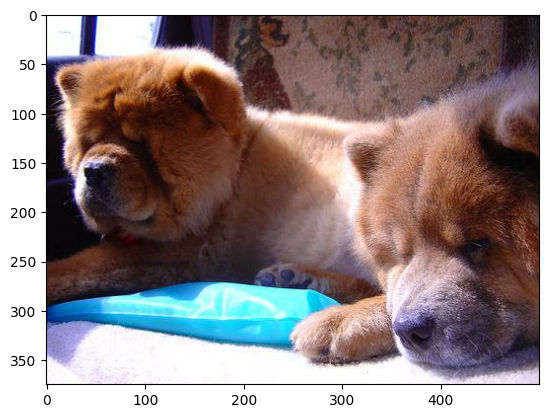

In [35]:
item_CAM = get_one(ds_test)
print(item_CAM['label'])
plt.imshow(item_CAM['image'])
plt.show()

2. 만든 함수로 CAM 이미지를 생성합시다.

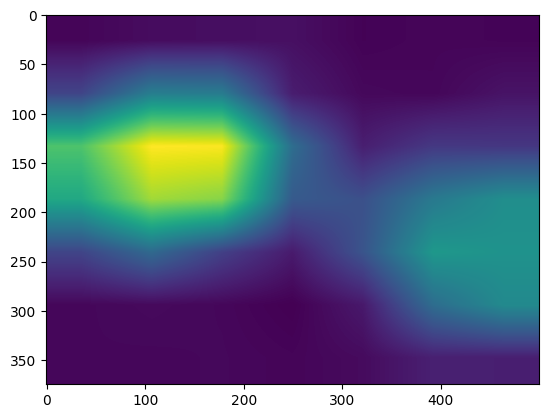

In [36]:
cam_image = generate_cam(cam_model, item_CAM)
plt.imshow(cam_image)
plt.show()


3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

- [webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)

In [37]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

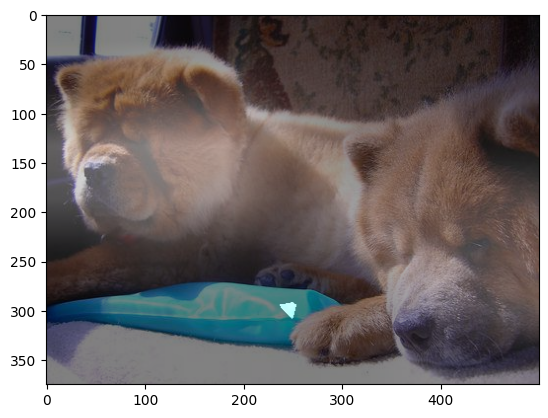

In [38]:
origin_image_CAM = item_CAM['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image_CAM)
plt.imshow(blended_image)
plt.show()

## Grad-CAM 구현하기
---
1. 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [18]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

108


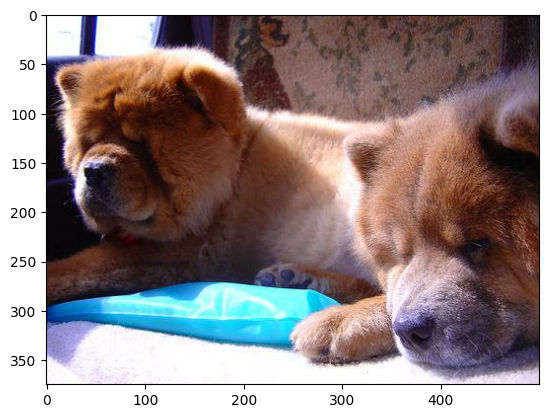

In [52]:
item_grad_CAM = get_one(ds_test)
print(item_grad_CAM['label'])
plt.imshow(item_grad_CAM['image'])
plt.show()

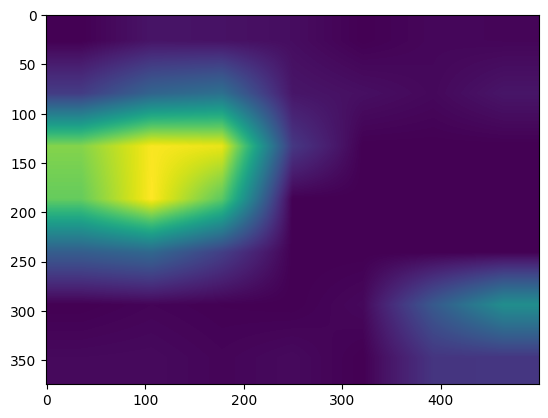

In [53]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item_grad_CAM)
plt.imshow(grad_cam_image)
plt.show()

3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

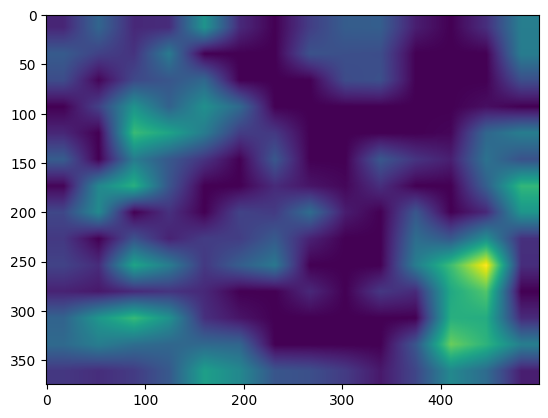

In [54]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item_grad_CAM)
plt.imshow(grad_cam_image)
plt.show()

## 바운딩 박스 구하기
---
1. 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

2. 1)에서 얻은 바운딩 박스를 시각화해 보세요.

In [55]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect


In [56]:
rect_CAM = get_bbox(cam_image)
rect_CAM

/var/folders/l5/xccndwgd1qd4v2sfh261kbpm0000gn/T/ipykernel_6404/1737992177.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect = np.int0(rect)


array([[  0, 373],
       [  0,  30],
       [498,  30],
       [498, 373]])

In [57]:
rect_grad_CAM= get_bbox(grad_cam_image)
rect_grad_CAM

/var/folders/l5/xccndwgd1qd4v2sfh261kbpm0000gn/T/ipykernel_6404/1737992177.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect = np.int0(rect)


array([[424,   0],
       [499,   0],
       [499,  87],
       [424,  87]])

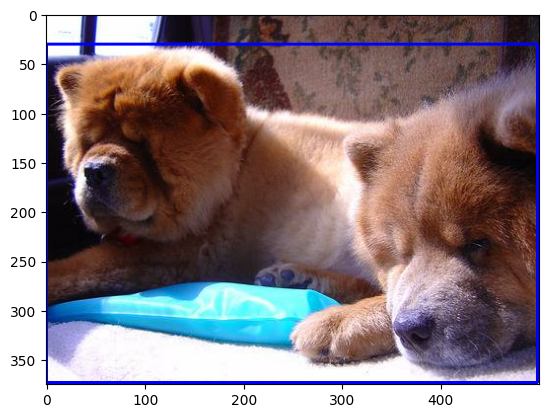

In [58]:
image_CAM = copy.deepcopy(item_CAM['image'])
image_CAM = cv2.drawContours(image_CAM, [rect_CAM], 0, (0,0,255), 2)
plt.imshow(image_CAM)
plt.show()

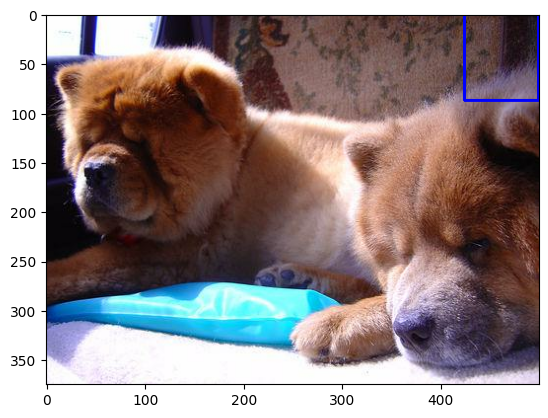

In [59]:
image_grad_CAM = copy.deepcopy(item_grad_CAM['image'])
image_grad_CAM = cv2.drawContours(image_grad_CAM, [rect_grad_CAM], 0, (0,0,255), 2)
plt.imshow(image_grad_CAM)
plt.show()

## IoU 구하기
---
1. 정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.


In [60]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [61]:
pred_bbox_CAM = rect_to_minmax(rect_CAM, item_CAM['image'])
pred_bbox_CAM

[0.08, 0.0, 0.9946666666666667, 0.996]

In [62]:
pred_bbox_grad_CAM = rect_to_minmax(rect_grad_CAM, item_CAM['image'])
pred_bbox_grad_CAM

[0.0, 0.848, 0.232, 0.998]

In [63]:
item_CAM['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

In [64]:
item_grad_CAM['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

In [32]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

2. CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [65]:
# 1. IoU of grad-CAM
get_iou(pred_bbox_CAM, item_CAM['objects']['bbox'][0])

0.46457894261807325

In [67]:
# 2. IoU of CAM
get_iou(pred_bbox_grad_CAM, item_grad_CAM['objects']['bbox'][0])

0.034135823781687974